In [6]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# 📘 Notebook 5 - Forecasting Future Returns using Advanced ML (LSTM/XGBoost)

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ✅ Load cleaned returns and cluster data
returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)
tsne_clusters = pd.read_csv("../data/tsne_clusters.csv", index_col=0)

# ✅ Filter assets based on cluster availability
assets = tsne_clusters.index.intersection(returns.columns)
returns = returns[assets]

In [8]:
# ✅ Feature Engineering: Create lag features
lags = 5
window_size = 252  # 1-year rolling window
forecast_horizon = 1  # 1-day ahead

# ✅ Function: Create lag features
def create_lag_features(series, lags=5, forecast_horizon=1):
    df = pd.DataFrame(index=series.index)
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = series.shift(lag)
    df["target"] = series.shift(-forecast_horizon)
    return df.dropna()

In [ ]:
# ✅ ML Models (using XGBoost for better speed + interpretability)
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
# ✅ Initialize storage
predicted_returns = {}
rmse_scores = {}
accuracy_scores = {}

# ✅ Forecast using rolling window
for ticker in assets:
    df = create_lag_features(returns[ticker], lags, forecast_horizon)
    preds, actual = [], []

    for i in range(len(df) - window_size):
        train = df.iloc[i:i+window_size]
        test = df.iloc[i+window_size:i+window_size+1]

        model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
        model.fit(train.drop(columns='target'), train['target'])

        pred = model.predict(test.drop(columns='target'))[0]
        preds.append(pred)
        actual.append(test['target'].values[0])

    # Final prediction for current day
    predicted_returns[ticker] = preds[-1]
    rmse = mean_squared_error(actual, preds, squared=False)
    acc = accuracy_score(np.sign(actual), np.sign(preds))

    rmse_scores[ticker] = rmse
    accuracy_scores[ticker] = acc

    print(f"{ticker} | RMSE: {rmse:.5f} | Directional Accuracy: {acc:.2%}")


AAPL | RMSE: 0.01862 | Directional Accuracy: 47.97%
ABBV | RMSE: 0.01539 | Directional Accuracy: 48.94%
ADBE | RMSE: 0.02108 | Directional Accuracy: 52.94%
AMGN | RMSE: 0.01482 | Directional Accuracy: 50.20%
AMZN | RMSE: 0.02126 | Directional Accuracy: 49.91%
AXP | RMSE: 0.01848 | Directional Accuracy: 50.66%
BAC | RMSE: 0.01962 | Directional Accuracy: 48.32%
BLK | RMSE: 0.01686 | Directional Accuracy: 50.71%
BMY | RMSE: 0.01407 | Directional Accuracy: 49.06%
BP | RMSE: 0.01903 | Directional Accuracy: 49.97%
C | RMSE: 0.02036 | Directional Accuracy: 49.00%
CI | RMSE: 0.01828 | Directional Accuracy: 49.52%
COP | RMSE: 0.02348 | Directional Accuracy: 49.34%
CRM | RMSE: 0.02094 | Directional Accuracy: 51.34%
CVS | RMSE: 0.01692 | Directional Accuracy: 47.97%
CVX | RMSE: 0.01773 | Directional Accuracy: 49.80%
DIS | RMSE: 0.01706 | Directional Accuracy: 51.63%
GOOG | RMSE: 0.01882 | Directional Accuracy: 49.40%
GS | RMSE: 0.01781 | Directional Accuracy: 50.60%
HAL | RMSE: 0.02821 | Directio

In [2]:
# ✅ Save predictions
predicted_df = pd.DataFrame.from_dict(predicted_returns, orient='index', columns=['predicted_return'])
predicted_df.index.name = 'Ticker'
predicted_df.to_csv("../data/predicted_returns.csv")
print("\n✅ Saved predicted returns to ../data/predicted_returns.csv")

# ✅ Save RMSE
rmse_df = pd.DataFrame.from_dict(rmse_scores, orient='index', columns=['RMSE'])
rmse_df.index.name = 'Ticker'
rmse_df.to_csv("../data/model_rmse_scores.csv")

# ✅ Save Accuracy
acc_df = pd.DataFrame.from_dict(accuracy_scores, orient='index', columns=['Accuracy'])
acc_df.index.name = 'Ticker'
acc_df.to_csv("../data/model_accuracy_scores.csv")
print("✅ Saved RMSE and Accuracy to CSVs")


NameError: name 'predicted_returns' is not defined

<Figure size 1200x500 with 0 Axes>

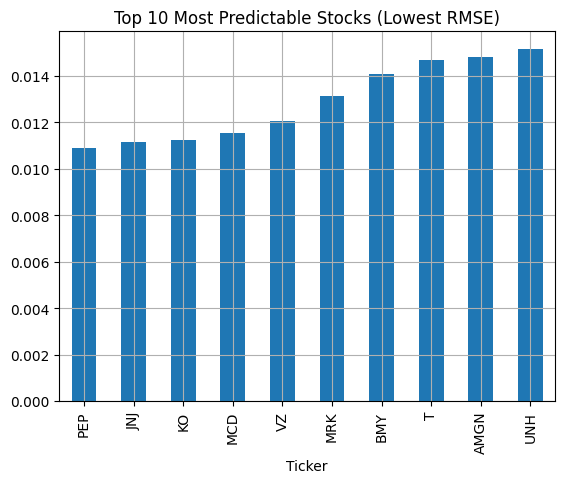

In [11]:
# ✅ Plot Top/Bottom Predictable Stocks
plt.figure(figsize=(12,5))
rmse_df.sort_values("RMSE").head(10).plot(kind='bar', legend=False)
plt.title("Top 10 Most Predictable Stocks (Lowest RMSE)")
plt.grid(True)
plt.show()

<Figure size 1200x500 with 0 Axes>

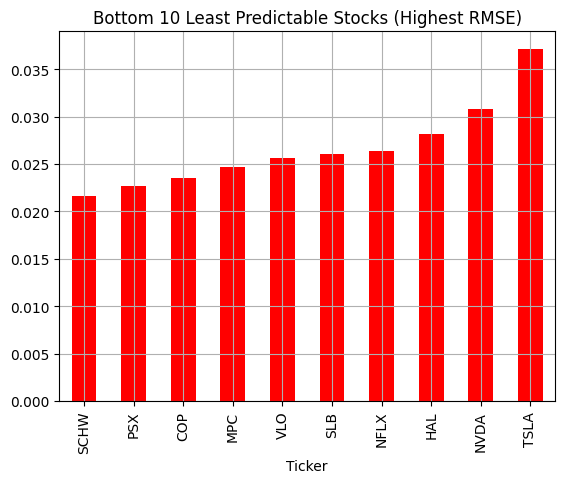

In [12]:
plt.figure(figsize=(12,5))
rmse_df.sort_values("RMSE").tail(10).plot(kind='bar', legend=False, color='red')
plt.title("Bottom 10 Least Predictable Stocks (Highest RMSE)")
plt.grid(True)
plt.show()

<Figure size 1200x500 with 0 Axes>

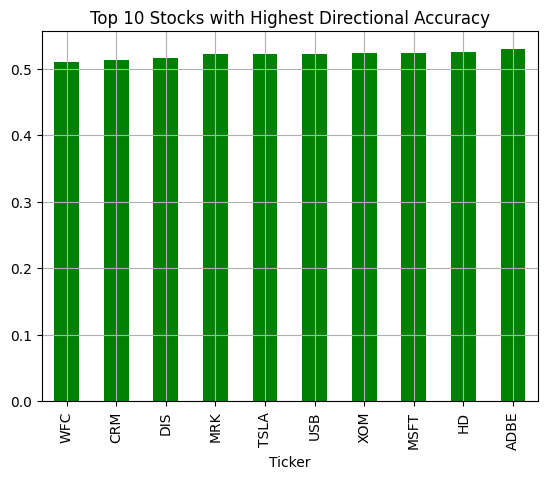

In [13]:
plt.figure(figsize=(12,5))
acc_df.sort_values("Accuracy").tail(10).plot(kind='bar', legend=False, color='green')
plt.title("Top 10 Stocks with Highest Directional Accuracy")
plt.grid(True)
plt.show()


In [1]:
# ✅ Load sector or cluster data if needed for group-based allocation
import pandas as pd
cluster_df = pd.read_csv("../data/tsne_clusters.csv", index_col=0)
cluster_df = cluster_df.loc[predicted_df.index]

# ✅ Combine predicted returns with cluster info
predicted_df['Cluster'] = cluster_df['Cluster']
cluster_groups = predicted_df.groupby('Cluster')

# ✅ Step 1: Allocate weights across clusters using mean predicted return
cluster_means = cluster_groups['predicted_return'].mean()
cluster_weights = cluster_means / cluster_means.sum()

# ✅ Step 2: Allocate weights within each cluster equally
# ✅ Step 2: Improved allocation within cluster based on individual predicted return
optimized_weights = pd.Series(0.0, index=predicted_df.index)


for cluster, group in predicted_df.groupby('Cluster'):
    pos_returns = group[group['predicted_return'] > 0]['predicted_return']
    if not pos_returns.empty:
        asset_weights = pos_returns / pos_returns.sum()
        optimized_weights.loc[asset_weights.index] = asset_weights * cluster_weights[cluster]

optimized_weights_df = pd.DataFrame({'Weight': optimized_weights})
optimized_weights_df.to_csv("../data/optimized_weights.csv")
print("✅ Saved cluster-mean-based optimized_weights.csv")


NameError: name 'predicted_df' is not defined

In [15]:
# 📘 ML-Driven Portfolio Optimization Using Predicted Returns

import cvxpy as cp
import pandas as pd
import numpy as np

# Step 1: Load forecasted returns
predicted_df = pd.read_csv("../data/predicted_returns.csv", index_col=0)
assets = predicted_df.index.tolist()
mu = predicted_df['predicted_return'].values

# Step 2: Historical covariance for risk
returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)
returns = returns[assets]
cov = returns.cov().values

# Step 3: Optimize (mean-variance)
n = len(assets)
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
# Entropy regularization to encourage diversification
entropy_term = cp.sum(cp.entr(w))  # Natural log of weights
risk_term = cp.quad_form(w, cov)
expected_return = mu @ w

# Parameters
lambda_risk = 0.5  # Risk aversion
lambda_entropy = 0.01  # Entropy regularization weight
w_max = 0.10  # Max 10% in any single asset

# Step 4: Define optimization problem
objective = cp.Maximize(expected_return - lambda_risk * risk_term + lambda_entropy * entropy_term)
constraints = [cp.sum(w) == 1, w >= 0, w <= w_max]

problem = cp.Problem(objective, constraints)
problem.solve()

# Step 5: Save clean weights
optimized_weights = pd.Series(w.value, index=assets, name='Weight')
optimized_weights = optimized_weights.round(6)
optimized_weights = optimized_weights[optimized_weights > 0]

# Save to CSV for Power BI
optimized_weights.to_csv("../data/optimized_weights_ml.csv")
print("✅ ML-based optimized weights (with diversification) saved to ../data/optimized_weights_ml.csv")


✅ ML-based optimized weights (with diversification) saved to ../data/optimized_weights_ml.csv
